In [1]:
from __future__ import division, print_function, absolute_import

import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression
import GenSyntheticMNSITFixedWidthModule as GenDataset
import numpy as np
import matplotlib.pyplot as plt

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


/home/ankdesh/installed/anaconda2/envs/tf0.11/lib/python2.7/gzip.py:275: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  chunk = self.extrabuf[offset: offset + size]
/home/ankdesh/installed/anaconda2/envs/tf0.11/lib/python2.7/site-packages/tflearn/datasets/mnist.py:52: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  data = data.reshape(num_images, rows, cols, 1)


In [2]:
# Consts
DATSET_SIZE = 100000
WIDTH_NUMS = 2

In [3]:
def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [4]:
# Get the dataset
X, Y = GenDataset.getDataSet(WIDTH_NUMS, DATSET_SIZE)
X = X.reshape([-1, 28, 28 * WIDTH_NUMS, 1])
Y = [dense_to_one_hot(Y[:,idx]) for idx in range(Y.shape[1])] 

In [5]:
print (Y[0].shape)

(100000, 10)


[array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]), array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.])]
(28, 56, 1)


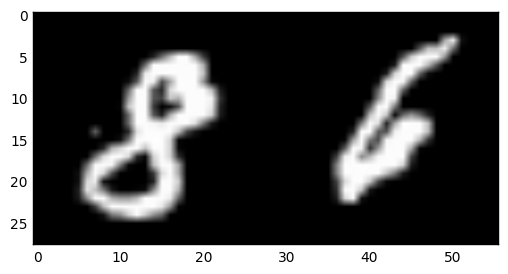

In [6]:
# Test a sample data
%matplotlib inline
idx = np.random.randint(0,DATSET_SIZE)
print ([Y[i][idx] for i in range(len(Y))])
print (X[idx].shape)
plt.imshow(np.squeeze(X[idx]), cmap = 'gray')

In [7]:
# Building convolutional network
network = input_data(shape=[None, 28, 28 * WIDTH_NUMS, 1], name='input')
network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")
network = max_pool_2d(network, 2)
network = local_response_normalization(network)
network = conv_2d(network, 64, 3, activation='relu', regularizer="L2")
network = max_pool_2d(network, 2)
network = local_response_normalization(network)
fc_1 = fully_connected(network, 128, activation='tanh')
fc_1 = dropout(fc_1, 0.8)
fc_2 = fully_connected(network, 128, activation='tanh')
fc_2 = dropout(fc_2, 0.8)
softmax1 = fully_connected(fc_1, 10, activation='softmax')
softmax2 = fully_connected(fc_2, 10, activation='softmax')
network1 = regression(softmax1, optimizer='adam', learning_rate=0.01,
                     loss='categorical_crossentropy', name='target1')
network2 = regression(softmax2, optimizer='adam', learning_rate=0.01,
                     loss='categorical_crossentropy', name='target2')
network = tflearn.merge([network1, network2], mode='elemwise_sum')

In [ ]:
model = tflearn.DNN(network, tensorboard_verbose=1)
model.fit({'input': X}, {'target1': Y[0], 'target2': Y[1]}, n_epoch=5, snapshot_step=100, show_metric=True, run_id='convnet_mnist')

Training Step: 3629  | total loss: 0.16736
| Adam_0 | epoch: 002 | loss: 0.06925 - acc: 0.9757 -- iter: 032192/100000
| Adam_1 | epoch: 002 | loss: 0.09811 - acc: 0.9714 -- iter: 032192/100000
